In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# for feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler

In [18]:
df = pd.read_csv('../data/train.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test = pd.read_csv('../data/test.csv', index_col=0)
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Preparation
1. Feature Selection
2. Splitting into train and test data
3. Feature Engineering

## Feature Selection:
Before actually selecting existing features, I want to extract the titles from the name column

In [19]:
titles = df['Name'].str.extract(',\s(\w+)\.')
titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Don           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Sir           1
dtype: int64

In [44]:
cabins = df['Cabin']
cabins.str[0]

df['Cabin']loc.isna()

PassengerId
1       True
2      False
3       True
4      False
5       True
       ...  
887     True
888    False
889     True
890    False
891     True
Name: Cabin, Length: 891, dtype: bool

Because there are a lot of different titles, I want to reduce them to five. This includes Mr, Miss, Mrs and Master, since there are already a lot observations. This means I have to match the other titles into the existing groups. I map them like this:
* `Mlle` and `Ms` to `Miss` 
* `Mme` to `Mrs`
* `Dr`, `Rev`, `Col`, `Major`, `Capt`, `Jonkheer`, `Lady` and `Sir` to `rest`

In [20]:
df['title'] = titles.replace({
     'Mlle': 'Miss', 
     'Ms': 'Miss', 
     'Mme': 'Mrs', 
     'Dr': 'rest', 
     'Don': 'rest',
     'Dona': 'rest', # found in test.csv
     'Rev': 'rest', 
     'Col': 'rest', 
     'Major': 'rest', 
     'Capt': 'rest', 
     'Jonkheer': 'rest', 
     'Lady': 'rest', 
     'Sir': 'rest'
})
df['title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
rest       22
Name: title, dtype: int64

In [23]:
df['family_size'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,family_size
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


Now that I got information about the titles of each passenger I have all the features I want to train my model.

In [77]:
# y = df['Survived']
X_test = df[['Pclass', 'Sex', 'Age', 'Fare', 'title', 'family_size']]

<AxesSubplot:ylabel='PassengerId'>

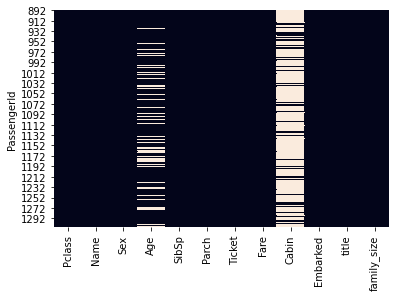

In [11]:
sns.heatmap(df_test.isnull(), cbar=False)

In [78]:
# Checking for missing values
X_test.isna().any()

Pclass         False
Sex            False
Age             True
Fare            True
title          False
family_size    False
dtype: bool

Checking titles, since I am responsible for that.  
Turns out my regex missed the Countess of somewhat which I would put into the titles-group `rest`.

In [30]:
# X.loc[X['title'].isna()]
df.iloc[759]
df['title'].iloc[759] = 'rest'
df.isna().any()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
title          False
family_size    False
dtype: bool

## Splitting the dataset into train and test

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Feature Engineering
1. Impute missing `age` value, then binning them into 5 groups
2. Scaling the `fare` into a range of 0 to 1
3. HotEncoding the `titles` and `sex`

In [24]:
impute_and_bin_age = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense', strategy = 'quantile')
)

impute_and_scale_fare = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    MinMaxScaler()
)

In [25]:
feat_eng = ColumnTransformer(
    transformers = [
        ('age_transformation', impute_and_bin_age, ['Age']),
        ('familiy_scale', MinMaxScaler(), ['family_size']),
        ('hot_titles', OneHotEncoder(), ['title', 'Sex']),
        ('impute_fare', impute_and_scale_fare, ['Fare'])
    ],
    remainder = 'passthrough'
)

In [65]:
feat_eng.fit(X_train)
X_train_trans = feat_eng.transform(X_train)

# Train the model:

In [ ]:
# Fitting the model on training data
model.fit(X_train_trans, y_train)

In [79]:
# Transform the test data
X_test_trans = feat_eng.transform(X_test)

# calculate predictions
y_pred = model.predict(X_test_trans)
# X_test_trans['prediction'] = pd.Series(model.predict(X_test_trans))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Evaluation

In [68]:
from sklearn import metrics

In [69]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}')

Accuracy: 0.8161434977578476 
Precision: 0.7411764705882353
Recall: 0.7682926829268293
F1 Score: 0.7544910179640718


In [18]:
metrics.confusion_matrix(y_test, y_pred)

array([[113,  28],
       [ 26,  56]])

1. feature engineering on train data
    2. feat_eng.fit(X_train)
    3. feat_eng.transform(X_train)
2. initialize model
3. model.fit(y_train, X_train_trans)
4. feature engineering on test data
5. X_train_tran = feat_eng.transform(X_train)
6. model.predict(X_train_trans)

In [31]:
X_train = df[['Pclass', 'Sex', 'Age', 'Fare', 'title', 'family_size']]
y_train = df['Survived']
X_test = df_test[['Pclass', 'Sex', 'Age', 'Fare', 'title', 'family_size']]

Pclass         False
Sex            False
Age             True
Fare           False
title          False
family_size    False
dtype: bool


<AxesSubplot:ylabel='PassengerId'>

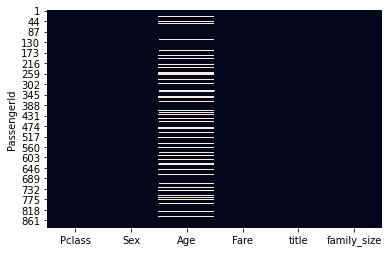

In [33]:
print(X_train.isna().any())
sns.heatmap(X_train.isnull(), cbar=False)

In [34]:
feat_eng.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('age_transformation',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='onehot-dense'))]),
                                 ['Age']),
                                ('familiy_scale', MinMaxScaler(),
                                 ['family_size']),
                                ('hot_titles', OneHotEncoder(),
                                 ['title', 'Sex']),
                                ('impute_fare',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinM

In [35]:
X_train_trans = feat_eng.transform(X_train)

In [36]:
X_test_trans = feat_eng.transform(X_test)

In [37]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_trans, y_train)

y_pred = model.predict(X_test_trans)

In [39]:
y_pred.shape

(418,)